<a href="https://colab.research.google.com/github/akin-oladejo/can-anomaly-detection-v2/blob/main/Detecting%20Attacks%20on%20the%20Renault%20CAN%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Attacks on CAN Data

## The Task
The Controller Area Network (CAN) is currently the most widely-used in-vehicle networking protocol. It is a bi-directional, multi-master, serial bus that uses UTP cabling to ensure reliability in electromagnetically noisy environments. Several devices in modern vehicles communicate with each other using the CAN protocol. Some of these devices are connected to the internet, allowing external attacks in various forms such as Replay, Spoofing, Denial of Service (DOS) and so on. In this project, different methods will be employed to detect attacks on the CAN.  

The methods are:
1. Frequency-based detection
2. Tree-based detection i.e. Isolation Forest
3. Anomaly detection using the latent representation of normal data i.e. autoencoders

Frequency-based detection is a heuristic approach; Isolation forest is a standard machine learning algorithm; the Autoencoder is a deep learning solution.



In [1]:
# Import libraries that will enable us perform this task

# data analysis libs
import pandas as pd
import numpy as np

# visualization libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning libs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.neighbors import LocalOutlierFactor
import torch as T

# utils
from dataclasses import dataclass
import joblib
from tqdm import tqdm
from collections import Counter
import json
import warnings
from datetime import timedelta

In [2]:
# config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# seed for PRNG's
rs = 42
np.random.seed(rs)
T.manual_seed(rs)

## The Dataset
The dataset used in this project is the **Automotive Controller Area Network (CAN) Bus Intrusion Dataset v2**. It can be found [here](https://figshare.com/articles/dataset/Automotive_Controller_Area_Network_CAN_Bus_Intrusion_Dataset/12696950). This dataset contains automotive Controller Area Network (CAN) bus data from three systems: two cars (Opel Astra and Renault Clio) and from a CAN bus prototype made by the authors of the dataset. Its purpose is to evaluate CAN bus Network Intrusion Detection Systems (NIDS). For each vehicle/system, there is a collection of log files captured from its CAN bus: normal (attack-free) data for training and testing detection algorithms, and different CAN bus attacks (Diagnostic, Fuzzing attacks, Replay attack, Suspension attack and Denial-of-Service attack).

For this project, I used data from the Renault Clio. The description of the different logs and attacks can be found in ../RenaultClio/README.md

## Preprocessing the datasets
For the analysis of the data that drives the following preprocessing steps, check the analysis notebook in the same directory as this notebook.
It will be helpful to define all the functionality we need for the different approaches in a utility class, `CANUtils`.



In [4]:
# uncomment outside of colab
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/datasets/road_data'

Mounted at /content/drive


In [5]:
# store the locations of the datasets
# data_path = 'data'
with open(f'../{data_path}/metadata.json', 'r') as f:
    dataset = json.load(f)

dataset.keys() # print keys

dict_keys(['train', 'test', 'validation'])

In [6]:
# view attacks in test folder
dataset['test'].keys()

dict_keys(['correlated_signal_attack', 'fuzzing_attack', 'max_speedometer_attack', 'reverse_light_off_attack', 'reverse_light_on_attack'])

In [7]:
# view attacks in validation folder
dataset['validation'].keys()

dict_keys(['correlated_signal_attack', 'fuzzing_attack', 'max_speedometer_attack', 'reverse_light_off_attack', 'reverse_light_on_attack'])

In [9]:
class ArbitrationEncoder():
    """
    Convert arbitration Id's into floats and normalize them. During transformation,
    previously unseen id's are stored using an unknown_value parameter that is either
    passed during instantiation or calculated as the negative of the number of unique valid ID's

    Example
    =======
    >>> enc = ArbitrationEncoder(unknown_value = -150)
    >>> enc.fit(df['arbitration_id'])
    >>> enc.transform(test_df['arbitration_id'])
    """
    def __init__(self, unknown_value:int|None=None):
        self.valid_ids = {}
        self.unknown_value = unknown_value if unknown_value else None

    @np.vectorize
    def make_float(self, val):
        """Convert hex to float"""
        return float(int(val, base=16)) # convert to float

    def fit(self, train_ids):
        """
        Determine the unique elements, standard deviation and mean of the input array.
        Also, calculate default value for unseen ID's if not passed at instantiation
        """
        # if isinstance(train_ids, pd.DataFrame):
        #     train_ids = arr.values
        self.valid_ids = set(train_ids) # get unique train id's
        self.converted_valid_ids = self.make_float(self,train_ids)
        self.std = np.std(self.converted_valid_ids) # calculate std
        self.mean = np.mean(self.converted_valid_ids) # calculate mean
        if not self.unknown_value:
            self.unknown_value = -(len(self.valid_ids))

    @np.vectorize
    def convert_and_scale(self, val):
        """
        Normalize array (compute the z-score). Note that all previously unseen values have the
        same transformation since `unknown_value` is a constant.
        """
        if not val in self.valid_ids:
            return (self.unknown_value - self.mean)/self.std
        else:
            converted_id = self.make_float(self, val) # convert from hex to float
            return (converted_id - self.mean)/self.std #return z score

    def transform(self, arr):
        """
        Transform array after running the `fit()` method
        """
        return self.convert_and_scale(self, arr)

    def fit_transform(self, arr):
        self.fit(arr)
        return self.transform(arr)

In [33]:
# define preprocessor class
class CANPrep():
    def __init__(self,
                 *,
                 dataset_path:str = data_path,
                 load_attack_from:str,
                 add_interval_feature:bool = True
                ):
        """
        Load and preprocess datasets; load standard scaler and one-hot encoder

        Parameters
        ========
        dataset_path: str. Path to the dataset
        load_attack_from: str. Possible values are {'train', 'test', 'validation'}
        """
        # to avoid wasting time, if load_attack_from argument is wrong, raise error
        if load_attack_from not in ['test', 'validation']:
            raise ValueError("Valid arguments for 'load_attack_from' parameter are 'test' and 'validation'")

        self.dataset_path = dataset_path
        self.message_scaler = StandardScaler()
        self.arbitration_encoder = ArbitrationEncoder()
        self.load_attack_from = load_attack_from

        # create a boolean and scaler for the interval feature if `add_interval_feature` == True
        if add_interval_feature:
            self.add_interval_feature = add_interval_feature
            self.interval_scaler = StandardScaler()

        # load and preprocess train dataset
        train_path = dataset['train']['path']
        self.train = self.load_csv(train_path, is_train=True) # generate train dataset

        # load and preprocess attack datasets, generate temporary labels of 0 for attack and normal data
        self.correlated_signal_attack_X, self.correlated_signal_attack_y = self.load_csv(dataset[self.load_attack_from]['correlated_signal_attack']['path'])
        self.fuzzing_attack_X, self.fuzzing_attack_y = self.load_csv(dataset[self.load_attack_from]['fuzzing_attack']['path'])
        self.max_speedometer_attack_X, self.max_speedometer_attack_y = self.load_csv(dataset[self.load_attack_from]['max_speedometer_attack']['path'])
        self.reverse_light_off_attack_X, self.reverse_light_off_attack_y = self.load_csv(dataset[self.load_attack_from]['reverse_light_off_attack']['path'])
        self.reverse_light_on_attack_X, self.reverse_light_on_attack_y = self.load_csv(dataset[self.load_attack_from]['reverse_light_on_attack']['path'])

        # finally, label attack data
        self.label_all_attacks()

    def load_csv(self, file_path:str, is_train:bool = False)->tuple|pd.DataFrame:
        """Read csv into dataframe and add headers"""
        df = pd.read_csv(data_path+file_path,
                         delimiter=' ',
                         names=['timestamp', '_', 'id_and_message'])

        return self.prep(df, is_train) # preprocess the df for model building

    def prep(self, df, is_train)->tuple|pd.DataFrame:
        """
        Encode categorical and Numeric features; scale numeric features;
        parse timestamp
        """
        id_and_message = df['id_and_message'].str.split('#', expand=True)

        # extract arbitration ID
        arbit_id = id_and_message[0].values # extract the arbitration ID

        # extract CAN packet data, convert to float and scale
        message = id_and_message[1].apply(lambda x: ' '.join(x[i:i+2] for i in range(0, len(x), 2))) # space out
        message = message.str.split(' ', expand=True) # split message into 8 features
        message.fillna('00', inplace=True) # pad short messages with 00 to make 8 features
        message = message.apply(lambda x : x.astype(str).map(lambda x : float(int(x, base=16)))) # convert hex values to float

        timesteps = df['timestamp'].apply(lambda x: x.strip('()')).astype('float').values # strip parentheses, parse to float
        if self.add_interval_feature:
            # shift the timesteps by one element and pad it at the end with the last value so a difference can be calculated
            shifted_timesteps = np.append(timesteps[1:], timesteps[-1])
            interval = (shifted_timesteps - timesteps).reshape(-1, 1) # add interval feature

        # parse the timestamp to datetime for use as an index
        time_index = pd.Series(pd.to_datetime(timesteps, unit='s'), name='timestamp') # convert epoch to datetime

        if is_train:
            # if this is train data, fit the encoders before transforming data
            arbit_id = self.arbitration_encoder.fit_transform(arbit_id) # fit and transform the arbitration_id in the train data
            message = self.message_scaler.fit_transform(message) # fit and transform `message` features
            if self.add_interval_feature:
                # fit_transform interval; concatenate message, interval and id
                interval = self.interval_scaler.fit_transform(interval)
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(interval), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)
            else:
                # concatenate message and id only
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)

            # return train data only as there are no labels
            return data

        else:
            # if this is not train data, only transform the data. do not fit encoders
            arbit_id = self.arbitration_encoder.transform(arbit_id)
            message = self.message_scaler.transform(message)
            if self.add_interval_feature:
                # transform interval; concatenate message,interval and id
                interval = self.interval_scaler.transform(interval)
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(interval), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)
            else:
                # concatenate message and id only
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)

            # `is_train` being False means this is an attack dataset, thus generate a temporary label series with all values being 0.
            # Attack timestamps in the label will be changed to 1 by the label_attack() method
            dummy_label = pd.Series(np.zeros(data.shape[0], dtype='int'), index=data.index)
            return data, dummy_label


    def ct(self, ts):
        """convert epoch timestamp to datetime object"""
        return pd.to_datetime(ts, unit='s')


    def label_attack(self, attack_data, attack_name:str):
        """
        Obtain the attack interval bounds from the metadata.json file and convert to datetime

        Parameters
        ==========
        attack_data: pd.Series. The temporary label to update
        attack_name: str. The name of the attack data so it can be searched up in the metadata file
        """
        # get attack interval in seconds
        attack_start_s, attack_stop_s = dataset[self.load_attack_from][attack_name]['injection_interval'] # interval bound

        # get start time in seconds
        record_start = attack_data.index[0]

        # label interval in timestamps by calculating the attack interval
        attack_start_t = record_start + timedelta(seconds=attack_start_s)
        attack_stop_t = record_start + timedelta(seconds=attack_stop_s)

        attack_data.loc[attack_start_t:attack_stop_t]=1 # replace 0's with 1's

        return attack_data


    def label_all_attacks(self):
        """Label attack timestamps in the attack datasets using the intervals provided in the metadata.json"""
        self.correlated_signal_attack_y = self.label_attack(self.correlated_signal_attack_y, 'correlated_signal_attack')
        self.fuzzing_attack_y = self.label_attack(self.fuzzing_attack_y, 'fuzzing_attack')
        self.max_speedometer_attack_y = self.label_attack(self.max_speedometer_attack_y, 'max_speedometer_attack')
        self.reverse_light_off_attack_y = self.label_attack(self.reverse_light_off_attack_y, 'reverse_light_off_attack')
        self.reverse_light_on_attack_y = self.label_attack(self.reverse_light_on_attack_y, 'reverse_light_on_attack')

In [34]:
road_dset = CANPrep(load_attack_from='test')

In [ ]:
road_dset.train.head(3)

,0,1,2,3,4,5,6,7,0,0
timestamp,,,,,,,,,,
2002-08-22 07:06:40.000000000,-0.742562,-0.693366,-0.721381,-0.726897,2.262620,-0.501874,2.015894,1.644356,-0.664669,-0.621172
2002-08-22 07:06:40.000002048,-0.742562,-0.584288,2.388608,-0.275816,-0.762142,-0.153693,0.841268,1.069590,-0.666383,-0.813723
2002-08-22 07:06:40.000002944,-0.742562,-0.802445,-0.721381,-0.764487,-0.775124,-0.729530,-0.850194,-0.929597,-0.666192,3.230873


In [42]:
road_dset.reverse_light_on_attack_X.head(3)

,0,1,2,3,4,5,6,7,0,0
timestamp,,,,,,,,,,
2008-12-23 02:40:00.000000000,-0.742562,-0.802445,-0.721381,-0.764487,-0.775124,-0.729530,-0.850194,-0.929597,-0.666383,3.230873
2008-12-23 02:40:00.000001024,1.361875,-0.802445,-0.323302,-0.764487,2.483310,0.984589,-0.850194,-0.917102,-0.666383,0.225228
2008-12-23 02:40:00.000001792,1.218391,0.356514,-0.335742,1.591158,0.626911,0.020397,-0.368597,-0.354831,-0.666002,0.003846


### Explaining the `CANUtils` class
The `CANUtils` class contains methods to process the data into valid input for machine learning algorithms. The initialization dunder, `__init__()`, loads the standard scaler and one hot encoder files and, with the `load_csv()` method, applies them to the numeric and categorical features in each dataset respectively.  
The `prep()` method is called after the csv files are loaded. It extracts and separates CAN ID from payload and converts the timestamps from epochs to `pd.Timestamp`, a more human-readable time format. It then returns the data and a temporary label (an array of zeros with the same number of rows as the data).



### Feature Engineering in the `CANUtils` class
\<missing info>  
#### Helper features
Usually with anomaly detection, the idea is to identify examples that do not conform to the properties of normal data. Isolation forest would, for instance, identify anomalies as data points with fewer splits; density estimation algorithms like DBSCAN and LocalOutlier Factor look at examples that occur in regions of low density.
The problem with anomalous CAN data is that most of the attack data resembles normal data:
- DOS for example is a series of valid data transmitted so many times that proper functioning of the CAN is inhibited — it is still very much valid data.
- replay attack in the dataset is just the repeated transmission of data with an arbitration id of `2C6` ten times more than regular. It is still a valid CAN id and the payload is still valid.


This presents a struggle — how does an algorithm that uses density estimation tell this kind of data apart from regular, normal data? The answer is in the nature of attack transmission. Here are some pointers:
1. Attacks generally increase CAN transmission rates. This is demonstrated in (Young, Olufowobi, Bloom & Zambreno, 2019) and is in fact the basis of approach 1.
2. Some CAN ID's are not seen as often, or even ever. Perhaps an increase in transmission rates from an ID indicates an anomaly? What happens when a CAN ID that never transmitted normally is seen during test? Will that help us identify anomalies?
3. Attack data can contain weird payloads. Take for instance the fuzzing payload attack.

To test that



### Labelling the anomalies
In the documentation, the authors declared the timestamps when the various attacks occurred. The `label_anomalies()` method uses that information to change the zeros at the attack timestamps in the temporary label to a value of 1. The attack timestamps are identified using the `ct()` method, which does the epoch-to-timestamp conversion so that the timestamps where attacks occurred can be labelled 1 correctly.

Thus, the label arrays for each attack dataset contains two classes: 1 for attack messages and 0 for normal messages.

This gives us the advantage of comparing predictions from the different methods and scoring them against a metric — the F1 score. The F1 score is the harmonic mean of the precision and recall of a model. It is a useful summary metric for scoring the performance of a model in predicting a class even when there are few samples of that class to predict.  

## A Pattern to the Three Approaches
For uniformity, each approach will be modeled as a class that implements the following methods:
- `__init__()`  
While the different approaches may create different attributes and call different methods upon object initialization, the different classes initialize a common attribute: `attack_f1`. `attack_f1` is a dictionary to store the F1 scores of each model on the different attack datasets. These values are visualized using the `chart_f1()` method.
- `fit()`  
The different approaches follow a common principle: learn the representation of normal activity. The `fit` method learns this representation differently for each approach: for approach 1 (message frequency detection), it learns the normal rate; for approach 2 (isolation forest), it learns the splits on normal data; for approach 3 (autoencoder), it learns a latent representation of normal data to arrive at a consistent error of reconstruction.
- `detect_anomalies()`  
This method uses the model's internal representation of normal data to detect an anomaly. When predictions have been made, it prints the classification report and stores the F1 score of the model on the target class in the model's `attack_f1` attribute.
- `chart_f1()`  
Each model defines a `chart_f1()` method to visualize the performance of the model on the different attack datasets as a barplot of F1 values.

## How the approaches will be scored
It is not enough that an approach detects anomalies. If the model were to predict wrongly most of the time, it would be annoying. We want the model to detect as many anomalies but not to the point where there are so many spurious detection. Hence we want a model that score a high true positive rate for the attack class and a low false positive rate so we don't have an incessant detector.

The uniformity of the three approaches allows us to define a single testing function, `test_approach`, that runs the `detect_anomalies()` method for each attack type and visualizes their scores:

In [43]:
def test_approach(model,
                  dset:CANPrep,
                  print_report:bool=False):

    attack_dict = {
        'Correlated Signal':{
            'test':dset.correlated_signal_attack_X,
            'label':dset.correlated_signal_attack_y
        },

        'Fuzzing':{
            'test':dset.fuzzing_attack_X,
            'label':dset.fuzzing_attack_y
        },

        'Max Speedometer':{
            'test':dset.max_speedometer_attack_X,
            'label':dset.max_speedometer_attack_y
        },

        'Reverse Light Off':{
            'test':dset.reverse_light_off_attack_X,
            'label':dset.reverse_light_off_attack_y
        },

        'Reverse Light On':{
            'test':dset.reverse_light_on_attack_X,
            'label':dset.reverse_light_on_attack_y
        },
    }

    for attack_name, data in attack_dict.items():
        preds = model.detect_anomalies(data['test'],
                                      data['label'],
                                      attack_name=attack_name,
                                      print_report=print_report,
                                      return_preds=print_report) # return the predictions

        if print_report:
            print(f"Predictions for '{attack_name}' attack:")
            print(Counter(preds))
            print('\n=================================================================')

    print(f'\nF1 Scores of the {model.model_name_} approach:')
    for i, j in model.attack_f1.items():
        print(f'{i:<20}: {round(j,5)}')

    print()
    model.chart_f1() # display f1 as barplot

## Approach 1: Frequency-based Detection
Young, Olufowobi, Bloom & Zambreno (2019) in the paper, "Automotive Intrusion Detection Based on Constant CAN
Message Frequencies Across Vehicle Driving Modes" propose that a more than double increase in the frequency of CAN message transmission is a simple indicator that <ins>there are anomalies in a CAN bus</ins>.

To implement the idea of this approach, a class, `Freq`, is defined. It defines a window (here, one second) and determines the average number of normal messages transmitted in that window. At inference time, if the frequency is greater than a given threshold, there is an anomaly.

Note that this approach only cares about *how many* messages were transmitted in each window and not what those messages were. For this, a dummy feature containing only the numeric value `1` is created and used to count the number of messages per second.

That average number of messages per second during normal CAN transmission is stored as `normal_rate` and then used in anomaly detection at inference time.

In [71]:
class Freq:
    def __init__(self, threshold):
        self.normal_rate:float|None = None
        self.confusion_matrix = None
        self.threshold = threshold
        self.model_name_ = 'Frequency Detection'

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def get_freq(self, df):
        """Obtain the frequency of CAN messages for each second"""
        # replace the data with a counting column but retain the timestamps
        df = pd.concat([pd.Series(df.index),
                        pd.Series(np.ones(df.shape[0]), name='message_count')], axis=1)

        # group by second
        freqs = df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).count()

        return freqs

    def fit(self, train_X:pd.DataFrame):
        """Obtain the normal rate by calculating average frequency of normal messages"""
        self.train_freqs = self.get_freq(train_X)
        self.normal_rate = self.train_freqs[1:-1].mean()
        print('Done')

    def predict(self, test_X:pd.DataFrame):
        self.test_freqs = self.get_freq(test_X)
        preds = (self.test_freqs > (self.threshold * self.normal_rate)).astype(int)
        return preds.loc[:,'message_count'].values

    def transform_labels(self, labels):
        """Transform the label by grouping by second"""
        label_df = labels.reset_index()
        labels = label_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).any().astype(int)
        # labels = label_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).sum()

        return labels

    def detect_anomalies(self, test_X, test_labels, attack_name, print_report=True, return_preds=False):
        labels = self.transform_labels(test_labels)

        # instantiate isolation forest model
        preds = self.predict(test_X)
        if print_report:
            print(f'Performance of the {self.model_name_} approach on {attack_name} attack:')
            print(classification_report(labels, preds))

        self.attack_f1[attack_name] = f1_score(labels, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        # ax = plt.bar(x, y)
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

When we call the `detect_anomalies` method of the `Freq` class above:
- the `normal_rate` is obtained from training data
- predictions are made using the `normal_rate` and the test data. Note that predictions show whether an anomaly occurred at a given second.
- the actual labels are processed so they indicate an anomaly occurred at a given second.
- the classification report is printed

Next, we use this class to predict anomalies for the different attack datasets and visualize the f1 scores for each attack type.

#### A personal observation
The authors' decision to make the threshold `2` (meaning that when the transmission rate doubles, there is an attack) may have been influenced by the nature of attacks they studied: injection attacks. For this dataset where there are, for instance, as many as 100,000 normal messages but only 10 diagnostic attacks, only mass injection attacks may be flagged as anomalous. It will be useful to use a more lenient value for threshold.   
  
Let's set the threshold value to 1.003 (so if there are on average 1405 messages per second, 1410 messages in a single second will indicate an attack)

In [72]:
# initialize the model on training data to get a value for normal rate
freq = Freq(threshold=1.003)
freq.fit(road_dset.train)
print(f'Normal rate of CAN transmission: {freq.normal_rate}')

Done
Normal rate of CAN transmission: message_count    2391.507901
dtype: float64


Let's test the frequency detection approach

Performance of the Frequency Detection approach on Correlated Signal attack:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.95      0.98        22

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34

Predictions for 'Correlated Signal' attack:
Counter({1: 21, 0: 13})

Performance of the Frequency Detection approach on Fuzzing attack:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87        17
           1       0.50      1.00      0.67         4

    accuracy                           0.81        21
   macro avg       0.75      0.88      0.77        21
weighted avg       0.90      0.81      0.83        21

Predictions for 'Fuzzing' attack:
Counter({0: 13, 1: 8})

Performance of the Frequency Detection approach on Max Speedometer attack:


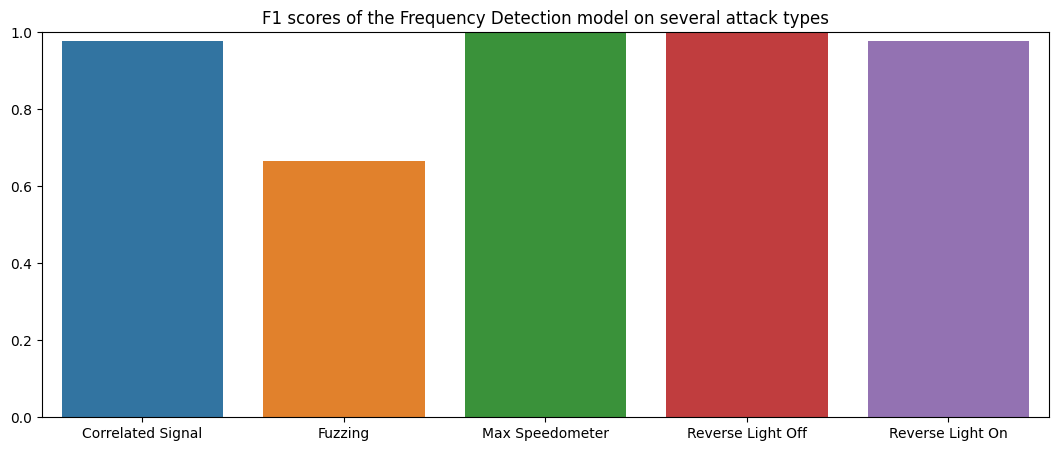

In [73]:
test_approach(model=freq,
              dset=road_dset,
              print_report=True)

The Frequency detection method isn't perfect, achieving less than 50% recall for most of the attack types. It is however useful in detecting DOS and replay attacks because that is the kind of problem this heuristic is suited for — injection attacks that blow the transmission rate.

## Approach 2: Density Estimation
<del>The Isolation Forest (Liu, Ting, and Zhou, 2008) is a tree-based anomaly detection algorithm that uses the path length of a data point in a decision tree to measure its isolation. Anomaly scores are assigned to data points based on their path lengths, and points with shorter path lengths are more likely to be anomalies:  
> Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.(“Sklearn.ensemble.IsolationForest,” 2023)

<del>Let's define a class, `IsoForest`, with a `detect_anomalies()` method that:
1. Fits an Isolation Forest model
2. Detect anomalies
3. Prints the classification report
4. Stores the f1 score for each attack type.

<del>The class will also have a `chart_f1()` method for comparing the f1 scores of the isolation forest approach on the different attack datasets.

In [80]:
class LOFactor():
    def __init__(self):
        # store f1 scores for visualization later
        self.attack_f1 = dict()
        self.model = LocalOutlierFactor(n_neighbors=50, novelty=True)
        self.model_name_ = 'Local Outlier Factor'

    def fit(self, train_X):
        self.model.fit(train_X)
        print('Done')

    def detect_anomalies(self, test_X, label, attack_name, print_report=True, return_preds=False):
        # contam = label.sum()/label.shape[0] # get the fraction of anomalies
        # make predictions and print classification
        preds = self.model.predict(test_X)
        preds = np.where(preds==1, 0, 1) # transform predictions
        if print_report:
            print(f'Performance of the {self.model_name_} approach on {attack_name}:')
            print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        sns.barplot(x=x, y=y)
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

Note that the predictions of the Isolation Forest model had to be transformed like {-1:1, 1:0} because the `fit_predict` method of `sklearn.IsolationForest` returns -1 for anomalies and 1 for inliers. The transformation was necessary so that it could correspond to the label with 0 representing normal data and 1 representing anomalies.

In [81]:
lof = LOFactor()
lof.fit(road_dset.train) # fit model

Done


Let's test the density-based approach


F1 Scores of the Local Outlier Factor approach:
Correlated Signal   : 0.4606
Fuzzing             : 0.24873
Max Speedometer     : 0.26714
Reverse Light Off   : 0.27867
Reverse Light On    : 0.29837



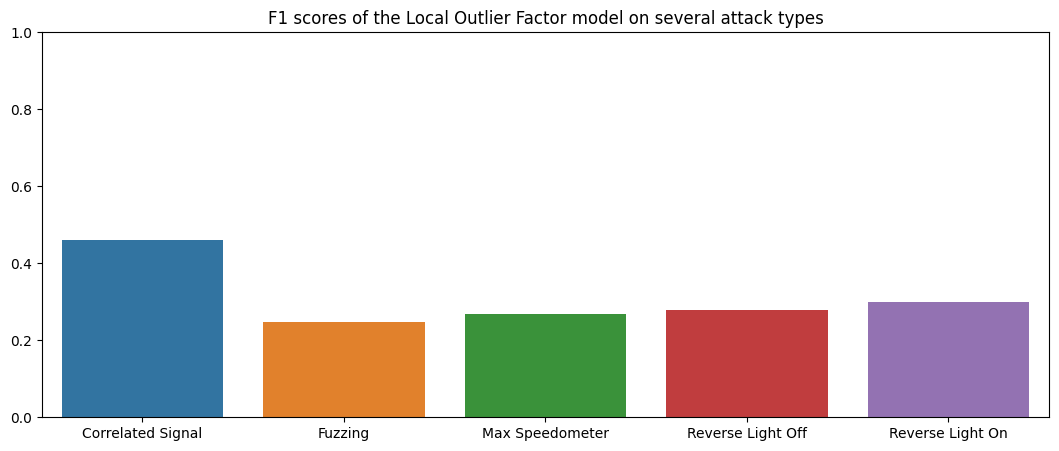

In [82]:
test_approach(model=lof,
              dset=road_dset,
              print_report=False)

## Approach 3: Anomaly detection using the latent representation of normal data
Alsaade and Al-Adhaileh (2023) in "Cyber Attack Detection for Self-Driving Vehicle Networks Using Deep Autoencoder Algorithms" employ the autoencoder approach to solve the anomaly detection problem.

Using an autoencoder, we train on only normal data. Predictions of abnormal data can be flagged because the error of reconstruction will usually be larger than the error reconstructing the normal data the model was trained on. This sounds like a good fit for the imbalance in the dataset.

Let's define the `AutoEncoder` class.

In [50]:
device = 'cuda:0' if T.cuda.is_available() else 'cpu' # choose the available device

In [75]:
class AutoEncoder(T.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.fc1 = T.nn.Linear(size, 32)
        self.fc2 = T.nn.Linear(32, 8)
        self.fc3 = T.nn.Linear(8, 32)
        self.fc4 = T.nn.Linear(32, size)
        self.threshold = 0.0
        self.model_name_ = 'Autoencoder'

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def encode(self, x):
        z = T.tanh(self.fc1(x))
        z = T.tanh(self.fc2(z))
        return z

    def decode(self, x):
        z = T.tanh(self.fc3(x))
        z = T.sigmoid(self.fc4(z))
        return z

    def forward(self, x):
        z = self.encode(x)
        z = self.decode(z)
        return z

    def rec_error(self, data):
        """Compute the reconstruction error when a sample is passed through the autoencoder"""
        # diff = autoenc(T.Tensor(data.values)).detach().numpy() - data.values
        input = T.Tensor(data.values).to(device)
        diff = (autoenc(input) - input).cpu().detach().numpy()
        error = np.mean(np.power(diff, 2), axis=1) # scalar error of reconstruction
        return error

    def set_threshold(self, value):
        self.threshold = value

    def zscore_threshold(self, input):
        """Compute the threshold as 1 z-score from the reconstruction errors of training data"""
        errors = self.rec_error(input) # compute errors of reconstruction

        self.set_threshold(np.mean(errors) + np.std(errors)) # set threshold to 1 z-score

    def fit(self, input, batch_size, epochs, log_interval, learning_rate):
        # set up loader object
        data_ldr = T.utils.data.DataLoader(T.Tensor(input.values).to(device),
                                        batch_size=batch_size,
                                        shuffle=True)

        loss_func = T.nn.MSELoss() # mean squared error loss
        opt = T.optim.SGD(self.parameters(), lr=learning_rate) # SGD optimizer

        print("\nStarting training")
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0.0 # reset loss
            for (batch_idx, batch) in enumerate(data_ldr):
                X = batch  # inputs
                Y = batch  # targets (same as inputs)

                opt.zero_grad() # prepare gradients
                output = self(X) # compute output/target
                loss_val = loss_func(output, Y) # compute loss/error
                epoch_loss += loss_val.item() # accumulate for display
                loss_val.backward() # compute gradients
                opt.step() # update weights

            if epoch % log_interval == 0:
                print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))

        self.zscore_threshold(input) # set the threshold using the training data
        print("Training completed!")

    def detect_anomalies(self, data_X, label, attack_name, print_report=True, return_preds=False):
        """
        Compute reconstruction error. If the error of a message exceeds the threshold
        default of (1 z score), it is predicted as an anomaly
        """

        errors = self.rec_error(data_X) # compute error of reconstruction
        preds = np.where(errors > self.threshold, 1, 0) # calculate predictions
        if print_report:
            print(f'Performance of the {self.model_name_} on {attack_name} attack:')
            print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

The `fit` method sets up the dataloader, loss function, optimizer and runs the training loop for the given number of epochs on the normal data.  
To be able to determine anomalies, a threshold error value will be calculated. Let's define the threshold to be 1 z-score i.e one standard deviation from the mean of errors of reconstruction. A reconstruction with an error exceeding that value is thus an anomaly.

Next, it is important that the autoencoder is just trained on only normal data so it only learns those patterns and not of the anomalies too. The `CANUtils().train` dataset contains only normal data so it will be used for training.

In [76]:
input = road_dset.train
autoenc = AutoEncoder(size=input.shape[1]).to(device)

Uncomment and run the next cell if you wish to train the autoencoder from scratch and save the weights:

In [77]:
autoenc.train() # set to train mode

autoenc.fit(input = road_dset.train,
            batch_size = 500,
            epochs = 20,
            log_interval = 50,
            learning_rate = 3e-3
            ) # train the model

T.save(autoenc.state_dict(), 'can-autoencoder.pt') # save the model


Starting training


  5%|▌         | 1/20 [00:06<02:01,  6.38s/it]

epoch =    0   loss = 2558.5357


100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


Training completed!


Otherwise, reload the state dict from prior training and use that for the model. Run the next cell:

In [78]:
# # load weights
# autoenc.load_state_dict(T.load('can-autoencoder.pt', map_location=device))

# # use 1 zscore of the input reconstruction errors array as the threshold
# autoenc.zscore_threshold(input)

# autoenc.eval() # set to eval mode

Performance of the Autoencoder on Correlated Signal attack:
              precision    recall  f1-score   support

           0       0.36      0.83      0.50     29289
           1       0.62      0.16      0.25     51973

    accuracy                           0.40     81262
   macro avg       0.49      0.49      0.38     81262
weighted avg       0.53      0.40      0.34     81262

Predictions for 'Correlated Signal' attack:
Counter({0: 67918, 1: 13344})

Performance of the Autoencoder on Fuzzing attack:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     40773
           1       0.22      0.19      0.20      8569

    accuracy                           0.75     49342
   macro avg       0.53      0.53      0.53     49342
weighted avg       0.73      0.75      0.74     49342

Predictions for 'Fuzzing' attack:
Counter({0: 42250, 1: 7092})

Performance of the Autoencoder on Max Speedometer attack:
              precision    recall  f1-s

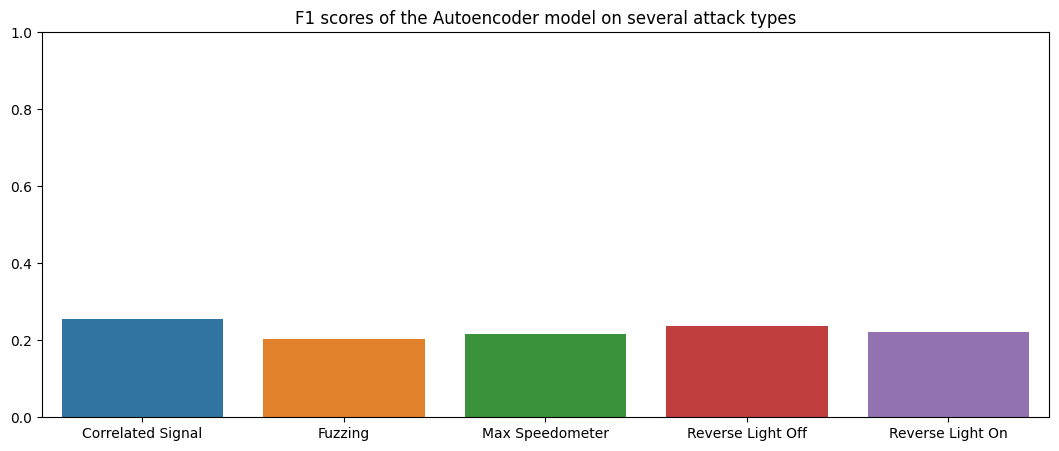

In [79]:
test_approach(model=autoenc,
              dset=road_dset,
              print_report=True)

## Conclusion
We have seen the results of the three approaches on anomaly detection. Several other methods exist. Some research papers use Long Short Term Memory (LSTM) and/or ConvNet architecture in place of Autoencoders, message intervals in place of frequency detection, support vectors instead of tree-based estimation and so on. Perhaps it is a good idea to build a classifier? Several roads lead to the market.

One thing that can be improved on in the various approaches above is hyperparameter tuning for the two machine learning approaches and a search across different threshold values for the frequency detection approach.

__________

## References
Alsaade, F. W., & Al-Adhaileh, M. H. (2023). Cyber Attack Detection for Self-Driving Vehicle Networks Using Deep Autoencoder Algorithms. Sensors, 23(8), 4086. https://doi.org/10.3390/s23084086

Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest. IEEE International Conference on Data Mining.

Narayanan, Sandeep & Mittal, Sudip & Joshi, Anupam. (2016). OBD_SecureAlert: An Anomaly Detection System for Vehicles. 1-6. 10.1109/SMARTCOMP.2016.7501710.

sklearn.ensemble.IsolationForest. (2023). Retrieved August 2, 2023, from scikit-learn website: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

Young, Clinton & Olufowobi, Habeeb & Bloom, Gedare & Zambreno, Joseph. (2019). Automotive Intrusion Detection Based on Constant CAN Message Frequencies Across Vehicle Driving Modes. 9-14. 10.1145/3309171.3309179.

Zhou, Li, & Shen. (2019). Anomaly Detection of CAN Bus Messages Using A Deep Neural Network for Autonomous Vehicles. Applied Sciences, 9(15), 3174. https://doi.org/10.3390/app9153174